In [1]:
#这次对小数据集进行词级别的机器翻译
import torch
import torch.utils.data as da
import torch.nn as nn
import torch.optim as optim
import jieba
import argparse
import matplotlib.pyplot as plt
from collections import Counter
import random
import time
from tqdm import tqdm
import torch.nn.functional as F
import pickle

In [2]:
torch.cuda.is_available()

True

In [26]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser()

parser.add_argument('--data_path', type=str, default='/data/renhongjie/文本摘要-指针网络/中文-新闻标题数据集/新闻标题数据集/train_text.txt',
                   help='数据集特征路径')
parser.add_argument('--label_path', type=str, default='/data/renhongjie/文本摘要-指针网络/中文-新闻标题数据集/新闻标题数据集/train_label.txt',
                   help='数据集标签路径')
parser.add_argument('--seq_len', type=int, default=60,
                   help='句子最大的长度，多则截断，少则补<unk>')
parser.add_argument('--pad', type=str, default='<unk>',
                   help='填充词')
parser.add_argument('--batch_size',type=int,default=32,
                   help='每轮批次')
parser.add_argument('--en_embedding_dim',type=int,default=256,
                   help='编码器词向量的长度')
parser.add_argument('--en_hidden_dim',type=int,default=512,
                   help='编码器深度')
parser.add_argument('--en_n_layers',type=int,default=2,
                   help='编码器LSTM的层数')
parser.add_argument('--de_embedding_dim',type=int,default=256,
                   help='解码器词向量的长度')
parser.add_argument('--de_hidden_dim',type=int,default=512,
                   help='解码器深度')
parser.add_argument('--de_n_layers',type=int,default=2,
                   help='解码器LSTM的层数')
parser.add_argument('--dropout',type=int,default=0.5,
                   help='droput')
parser.add_argument('--lr',type=int,default=0.0001,
                   help='学习率')
parser.add_argument('--weight_decay',type=int,default=0.1,
                   help='权重衰减/L2范式')
parser.add_argument('--clip',type=int,default=1,
                   help='梯度剪切')
parser.add_argument('--epochs',type=int,default=200,
                   help='训练轮数')
parser.add_argument('--attn_method',type=str,default='general',
                   help='启用注意力机制')

#kwargs = parser.parse_args()
kwargs = parser.parse_known_args()[0]

In [4]:
#对两个数据集的每句话进行分词
def get_token_data(data,label):
    data_token = []
    label_token = []
    for d,l in tqdm(zip(data,label)):
        d,l=get_token_text(d,l)
        data_token.append(d)
        label_token.append(l)
    return data_token,label_token

In [5]:
#对单句话进行分词
def get_token_text(d,l):
    #简单的句子处理
    d=d.replace('.',' .').replace('?',' ?').replace('!',' !').replace(',',' , ')
    l=l.replace('.',' .').replace('?',' ?').replace('!',' !').replace(',',' , ')
    #中文一般用jieba
    token_data = [st for st in jieba.cut(d)]
    token_label = [st for st in jieba.cut(l)]
    return [token_data,token_label]

In [6]:
def get_vocab(data):
    data=[j for i in data for j in i]
    top_1000 = Counter(data).most_common(200000)
    vocab = {x[0]:x[1] for x in top_1000}
    word_to_idx = {word: i + 4 for i, word in enumerate(vocab)}
    word_to_idx['<pad>'] = 0
    word_to_idx['<sos>'] = 1
    word_to_idx['<eos>'] = 2
    word_to_idx['<unk>'] = 3
    idx_to_word = {i + 4: word for i, word in enumerate(vocab)}
    idx_to_word[0] = '<pad>'
    idx_to_word[1] = '<sos>'
    idx_to_word[2] = '<eos>'
    idx_to_word[3] = '<unk>'
    vocab_size=len(idx_to_word)
    return vocab, vocab_size, word_to_idx, idx_to_word

In [7]:
# 转化为索引
def encode_st(token_data, word_to_idx):
    features = []
    for sample in token_data:
        feature = []
        feature.append(1)
        for token in sample:
            if token in word_to_idx:
                feature.append(word_to_idx[token])
            else:#如果是词库中不存在的，认为是<unk>，即0
                feature.append(0)
        feature.append(2)
        features.append(feature)
    
    return features

In [8]:
#用一个小数据集合先玩玩
with open(kwargs.data_path, 'r', encoding='utf-8') as f:
    data = f.read()

with open(kwargs.label_path, 'r', encoding='utf-8') as f:
    label = f.read()
data = data.strip().split('\n')
label= label.strip().split('\n')

In [9]:
print(len(data))

679898


In [10]:
datanew=[]
labelnew=[]
for i,j in zip(data,label):
    if len(i)>120 or len(j)>30:
        continue
    datanew.append(i)
    labelnew.append(j)


In [11]:
print(len(datanew))

229512


In [12]:
#此时为二维数组，每个数组是之前每句话的分词结果，词级别
data,label=get_token_data(datanew,labelnew)

0it [00:00, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/jieba/__init__.py", line 154, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmpocxhsidp' -> '/tmp/jieba.cache'
Loading model cost 0.918 seconds.
Prefix dict has been built successfully.
229512it [01:54, 2000.23it/s]


In [13]:
vocab,vocab_size, word_to_idx, idx_to_word=get_vocab(data)#682626


In [14]:
kwargs.vocab_size=vocab_size

In [15]:
print(vocab_size)

200004


In [16]:
#此时为二维数组，每个数组是之前每句话的分词结果，词级别
token_data=encode_st((data),word_to_idx)
token_label=encode_st((label),word_to_idx)


In [17]:
print(token_label[0:1])
print(token_data[0:1])

[[1, 40872, 27032, 6819, 32, 16, 163, 859, 124, 31310, 9739, 35, 14138, 34, 2]]
[[1, 5306, 7640, 4, 12219, 27739, 4, 6819, 32, 1287, 72, 163, 17461, 31310, 9739, 1526, 15014, 11906, 28, 5020, 4, 15387, 5481, 4, 6819, 32, 22799, 21, 10352, 40872, 27032, 35, 331, 112, 30293, 34, 45335, 39056, 74, 7, 105, 104, 74, 6, 5, 5, 5, 2]]


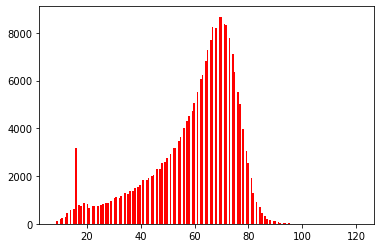

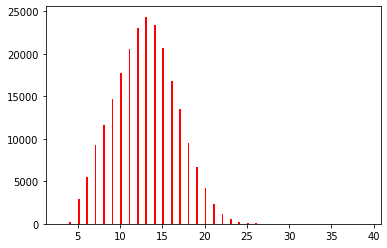

In [18]:
#看一下预料的长度分布，然后选择一个合适的seq_len
en_data_length=[]
for i in token_data:
    en_data_length.append(len(i))
n, bins, patches = plt.hist(en_data_length, bins=180, edgecolor='None',facecolor='red') 
plt.show()
zh_data_length=[]
for i in token_label:
    zh_data_length.append(len(i))
n, bins, patches = plt.hist(zh_data_length, bins=180, edgecolor='None',facecolor='red') 
plt.show()

In [19]:
with open('token_data.npy', 'wb') as file1:
    pickle.dump(token_data, file1)
with open('token_label.npy', 'wb') as file2:
    pickle.dump(token_label, file2)
with open('idx_to_word.npy', 'wb') as file3:
    pickle.dump(idx_to_word, file3)
with open('word_to_idx.npy', 'wb') as file0:
    pickle.dump(word_to_idx, file0)
file0.close()
file1.close()
file2.close()
file3.close()

In [34]:
with open('token_data.npy', 'rb') as file4:
    token_data=pickle.load(file4)
with open('token_label.npy', 'rb') as file5:
    token_label=pickle.load(file5)
with open('idx_to_word.npy', 'rb') as file6:
    idx_to_word=pickle.load(file6)
with open('word_to_idx.npy', 'rb') as file7:
    word_to_idx=pickle.load(file7)
kwargs.vocab_size=len(idx_to_word)

In [35]:
print(len(token_data))

229512


In [36]:
from torch.utils.data import Dataset, DataLoader
class TranslationDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

        assert len(data) == len(label), \
            "numbers of src_data  and trg_data must be equal!"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_sample =self.data[idx]
        data_len = len(self.data[idx])
        label_sample = self.label[idx]
        label_len = len(self.label[idx])
        return {"data": data_sample, "data_len": data_len, "label": label_sample, "label_len": label_len}

In [37]:
def padding_batch(batch):
    """
    input: -> list of dict
        [{'src': [1, 2, 3], 'trg': [1, 2, 3]}, {'src': [1, 2, 2, 3], 'trg': [1, 2, 2, 3]}]
    output: -> dict of tensor 
        {
            "src": [[1, 2, 3, 0], [1, 2, 2, 3]].T
            "trg": [[1, 2, 3, 0], [1, 2, 2, 3]].T
        }
    """
    data_lens = [d["data_len"] for d in batch]
    label_lens = [d["label_len"] for d in batch]
    
    data_max = max([d["data_len"] for d in batch])
    label_max = max([d["label_len"] for d in batch])
    for d in batch:
        word_to_idx
        d["data"].extend([word_to_idx["<pad>"]]*(data_max-d["data_len"]))
        d["label"].extend([word_to_idx["<pad>"]]*(label_max-d["label_len"]))
    data = torch.tensor([pair["data"] for pair in batch], dtype=torch.long, device=device)
    label = torch.tensor([pair["label"] for pair in batch], dtype=torch.long, device=device)
    
    batch = {"data":data.T, "data_len":data_lens, "label":label.T, "label_len":label_lens}
    return batch

In [27]:
# 数据集
train_set = TranslationDataset(token_data, token_label)
train_iter = DataLoader(train_set, batch_size=16, collate_fn=padding_batch)

In [28]:
#开始模型部分
class Encoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.input_dim = args.vocab_size
        self.emb_dim = args.en_embedding_dim
        self.hid_dim = args.en_hidden_dim
        self.n_layers = args.en_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.input_dim, self.emb_dim)   
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim, num_layers=self.n_layers,
                           dropout=self.dropout,bidirectional=True)

        
    def forward(self, x,input_lengths):
        embedded = (self.embedding(x))
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=False)
        outputs, (hidden, cell) = self.rnn(packed)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(sequence=outputs)
        return outputs,hidden, cell
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)  # [seq_len, batch]

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)  # [seq_len, batch, hid_dim]
        return torch.sum(hidden * energy, dim=2)  # [seq_len, batch]

    def concat_score(self, hidden, encoder_output):
        # hidden.expand(encoder_output.size(0), -1, -1) -> [seq_len, batch, N]
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        # energy = [sql_len, batch, hidden_size]
        return torch.sum(self.v * energy, dim=2)  # [seq_len, batch]

    def forward(self, hidden, encoder_outputs):
        # hidden = [1, batch,  n_directions * hid_dim]
        # encoder_outputs = [seq_len, batch, hid dim * n directions]
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        attn_energies = attn_energies.t()  # [batch, seq_len]
 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # softmax归一化# [batch, 1, seq_len]
class DecoderAtten(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.attn_method=args.attn_method
        self.emb_dim = args.de_embedding_dim
        self.hid_dim = args.de_hidden_dim
        self.output_dim = args.vocab_size
        self.n_layers = args.de_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim,num_layers= self.n_layers,
                           dropout=self.dropout,bidirectional=True)
        
        bidirectional=True
        if bidirectional:
            self.concat = nn.Linear(self.hid_dim * 2 * 2, self.hid_dim*2)
            self.out = nn.Linear(self.hid_dim*2, self.output_dim)
            self.attn = Attn(self.attn_method, self.hid_dim*2)
            self.prt=nn.Linear(self.hid_dim * 2,1)
        else:
            self.concat = nn.Linear(self.hid_dim * 2, self.hid_dim)
            self.out = nn.Linear(self.hid_dim, self.output_dim)
            self.attn = Attn(self.attn_method, self.hid_dim)
            self.prt=nn.Linear(self.hid_dim,1)
        self.de_dropout = nn.Dropout(args.dropout)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden, cell,encoder_outputs):
        batch_size = x.size(0)
        embedded = self.embedding(x)
        embedded = self.de_dropout(embedded)
        embedded = embedded.view(1, batch_size, -1) # [1, B, hid_dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))    
        
        attn_weights = self.attn(output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        
        output = output.squeeze(0) # [batch, n_directions * hid_dim]
        context = context.squeeze(1)       # [batch, n_directions * hid_dim]
        concat_input = torch.cat((output, context), 1)  # [batch, n_directions * hid_dim * 2]
        concat_output = torch.tanh(self.concat(concat_input))  # [batch, n_directions*hid_dim]

        
        
        output = self.out(concat_output)
        #prediction = self.softmax(output)
        #return prediction, hidden, cell,attn_weights
        #context用于计算选择网络的参数
        prob_ptr=F.sigmoid(self.prt(context))
        return output, hidden, cell,attn_weights,prob_ptr

class Seq2Seq(nn.Module):
    def __init__(self, args,device):
        super().__init__()
        self.encoder = Encoder(args)
       
        self.decoder = DecoderAtten(args)
        
        self.device = device
        assert self.encoder.hid_dim == self.decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert self.encoder.n_layers == self.decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        assert self.encoder.rnn.bidirectional == self.decoder.rnn.bidirectional, \
            "Decoder and encoder must had same value of bidirectional attribute!"   
    def forward(self, data, label, data_length,label_length,pointer = True):
        batch_size = label.shape[1]
        trg_vocab_size = self.decoder.output_dim
        max_label_length = max(label_length)
        max_data_length = max(data_length)
        outputs = torch.zeros(max_label_length, batch_size, trg_vocab_size).to(self.device)
        en_outputs,hidden, cell = self.encoder(data,data_length)   
        #输入到Decoder网络的第一个字符是<sos>（句子开始标记）
        de_input = label[0]
        data=data.transpose(1,0)
        atten=torch.zeros(max_label_length,batch_size, max_data_length).to(self.device)
        for t in range(max_label_length):
            #注意前面的hidden、cell和后面的是不同的
#             if self.attention==True:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell,en_outputs)
#             else:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell)
#             outputs[t] = output
            
            if not pointer:
                    output, decoder_hidden, cell,decoder_attn,_ = self.decoder(de_input, hidden, cell,en_outputs)
                    decoder_attn=decoder_attn.squeeze(1)
                    topv, topi = output.topk(1)
                    outputs[t] = output
                    output = topi.squeeze(1)
            else:
                    output, decoder_hidden, cell,decoder_attn,prob_ptr = self.decoder(de_input, hidden, cell,en_outputs)
                    # [batch, 1]
                    decoder_attn=decoder_attn.squeeze(1)
                    prob_gen = 1 - prob_ptr
                    output=output*prob_gen
#                     print(prob_ptr.shape,decoder_attn.shape)
#                     print(data.shape,(prob_ptr*decoder_attn).shape,output.shape)
                    output.scatter_add_(1,data,prob_ptr*decoder_attn)
                    topv, topi = output.topk(1)
                    outputs[t] = output
                    output = topi.squeeze(1)  #
#             print('decoder_attn',decoder_attn.shape)
#             print('atten',atten.shape)
#             print('output',output.shape)
#             print('decoder_hidden',decoder_hidden.shape)
#             print('outputs',outputs.shape)
#             print('en_outputs',en_outputs.shape)
#             print('hidden',hidden.shape)
            
#             print('output',output)
#             print('outputs',outputs[t])
            atten[t]=(decoder_attn)
#             os.exit()
        return outputs,atten

In [29]:
# #开始模型部分
# class Encoder(nn.Module):
#     def __init__(self, args):
#         super().__init__()
#         self.input_dim = args.vocab_size
#         self.emb_dim = args.en_embedding_dim
#         self.hid_dim = args.en_hidden_dim
#         self.n_layers = args.en_n_layers
#         self.dropout = args.dropout
#         self.embedding = nn.Embedding(self.input_dim, self.emb_dim)   
#         self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim, num_layers=self.n_layers,
#                            dropout=self.dropout,bidirectional=True)

        
#     def forward(self, x,input_lengths):
#         embedded = (self.embedding(x))
#         packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=False)
#         outputs, (hidden, cell) = self.rnn(packed)
#         outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(sequence=outputs)
#         return outputs,hidden, cell
# class Attn(nn.Module):
#     def __init__(self, method, hidden_size):
#         super(Attn, self).__init__()
#         self.method = method
#         if self.method not in ['dot', 'general', 'concat']:
#             raise ValueError(self.method, "is not an appropriate attention method.")
#         self.hidden_size = hidden_size
#         if self.method == 'general':
#             self.attn = nn.Linear(self.hidden_size, hidden_size)
#         elif self.method == 'concat':
#             self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
#             self.v = nn.Parameter(torch.FloatTensor(hidden_size))

#     def dot_score(self, hidden, encoder_output):
#         return torch.sum(hidden * encoder_output, dim=2)  # [seq_len, batch]

#     def general_score(self, hidden, encoder_output):
#         energy = self.attn(encoder_output)  # [seq_len, batch, hid_dim]
#         return torch.sum(hidden * energy, dim=2)  # [seq_len, batch]

#     def concat_score(self, hidden, encoder_output):
#         # hidden.expand(encoder_output.size(0), -1, -1) -> [seq_len, batch, N]
#         energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
#         # energy = [sql_len, batch, hidden_size]
#         return torch.sum(self.v * energy, dim=2)  # [seq_len, batch]

#     def forward(self, hidden, encoder_outputs):
#         # hidden = [1, batch,  n_directions * hid_dim]
#         # encoder_outputs = [seq_len, batch, hid dim * n directions]
#         if self.method == 'general':
#             attn_energies = self.general_score(hidden, encoder_outputs)
#         elif self.method == 'concat':
#             attn_energies = self.concat_score(hidden, encoder_outputs)
#         elif self.method == 'dot':
#             attn_energies = self.dot_score(hidden, encoder_outputs)

#         attn_energies = attn_energies.t()  # [batch, seq_len]
 
#         return F.softmax(attn_energies, dim=1).unsqueeze(1)  # softmax归一化# [batch, 1, seq_len]
# class DecoderAtten(nn.Module):
#     def __init__(self, args):
#         super().__init__()
#         self.attn_method=args.attn_method
#         self.emb_dim = args.de_embedding_dim
#         self.hid_dim = args.de_hidden_dim
#         self.output_dim = args.vocab_size
#         self.n_layers = args.de_n_layers
#         self.dropout = args.dropout
#         self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
#         self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim,num_layers= self.n_layers,
#                            dropout=self.dropout,bidirectional=True)
        
#         bidirectional=True
#         if bidirectional:
#             self.concat = nn.Linear(self.hid_dim * 2 * 2, self.hid_dim*2)
#             self.out = nn.Linear(self.hid_dim*2, self.output_dim)
#             self.attn = Attn(self.attn_method, self.hid_dim*2)
#             self.prt=nn.Linear(self.hid_dim * 2,1)
#         else:
#             self.concat = nn.Linear(self.hid_dim * 2, self.hid_dim)
#             self.out = nn.Linear(self.hid_dim, self.output_dim)
#             self.attn = Attn(self.attn_method, self.hid_dim)
#             self.prt=nn.Linear(self.hid_dim,1)
#         self.de_dropout = nn.Dropout(args.dropout)
#         self.softmax = nn.LogSoftmax(dim=1)
        
#     def forward(self, x, hidden, cell,encoder_outputs):
#         batch_size = x.size(0)
#         embedded = self.embedding(x)
#         embedded = self.de_dropout(embedded)
#         embedded = embedded.view(1, batch_size, -1) # [1, B, hid_dim]
#         output, (hidden, cell) = self.rnn(embedded, (hidden, cell))    
#         print('解码器里面RNN的output, (hidden, cell)输出结果：',output.shape, hidden.shape, cell.shape)
#         attn_weights = self.attn(output, encoder_outputs)
#         print("attn_weights:",attn_weights.shape)
#         print("encoder_outputs:",encoder_outputs.shape)
#         context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
#         print("context:",context.shape)
        
#         output = output.squeeze(0) # [batch, n_directions * hid_dim]
#         context = context.squeeze(1)       # [batch, n_directions * hid_dim]
        
#         concat_input = torch.cat((output, context), 1)  # [batch, n_directions * hid_dim * 2]
#         concat_output = torch.tanh(self.concat(concat_input))  # [batch, n_directions*hid_dim]
#         print("concat_input",concat_input.shape)
#         print("concat_output",concat_output.shape)
        
#         output = self.out(concat_output)
#         print("output",concat_input.shape)
#         #prediction = self.softmax(output)
#         #return prediction, hidden, cell,attn_weights
#         #context用于计算选择网络的参数
#         prob_ptr=F.sigmoid(self.prt(context))
#         print("prob_ptr",prob_ptr.shape)
#         return output, hidden, cell,attn_weights,prob_ptr

# class Seq2Seq(nn.Module):
#     def __init__(self, args,device):
#         super().__init__()
#         self.encoder = Encoder(args)
       
#         self.decoder = DecoderAtten(args)
        
#         self.device = device
#         assert self.encoder.hid_dim == self.decoder.hid_dim, \
#             "Hidden dimensions of encoder and decoder must be equal!"
#         assert self.encoder.n_layers == self.decoder.n_layers, \
#             "Encoder and decoder must have equal number of layers!"
#         assert self.encoder.rnn.bidirectional == self.decoder.rnn.bidirectional, \
#             "Decoder and encoder must had same value of bidirectional attribute!"   
#     def forward(self, data, label, data_length,label_length,pointer = True):
#         print('刚进入模型的原始数据x：',data.shape)
#         batch_size = label.shape[1]
#         trg_vocab_size = self.decoder.output_dim
#         max_label_length = max(label_length)
#         max_data_length = max(data_length)
#         outputs = torch.zeros(max_label_length, batch_size, trg_vocab_size).to(self.device)
#         en_outputs,hidden, cell = self.encoder(data,data_length)
#         print('经过编码器后输出的en_outputs,hidden, cell：',en_outputs.shape,hidden.shape, cell.shape)
#         #输入到Decoder网络的第一个字符是<sos>（句子开始标记）
#         de_input = label[0]
#         data=data.transpose(1,0)
#         print("输入模型的第一个字符：",data.shape)
#         atten=torch.zeros(max_label_length,batch_size, max_data_length).to(self.device)
#         for t in range(max_label_length):
#             #注意前面的hidden、cell和后面的是不同的
# #             if self.attention==True:
# #                 output, hidden, cell = self.decoder(de_input, hidden, cell,en_outputs)
# #             else:
# #                 output, hidden, cell = self.decoder(de_input, hidden, cell)
# #             outputs[t] = output
            
#             if not pointer:
#                     output, decoder_hidden, cell,decoder_attn,_ = self.decoder(de_input, hidden, cell,en_outputs)
#                     decoder_attn=decoder_attn.squeeze(1)
#                     topv, topi = output.topk(1)
#                     outputs[t] = output
#                     output = topi.squeeze(1)
#             else:
#                     output, decoder_hidden, cell,decoder_attn,prob_ptr = self.decoder(de_input, hidden, cell,en_outputs)
#                     print("output, decoder_hidden, cell,decoder_attn,prob_ptr:",output.shape, decoder_hidden.shape, cell.shape,decoder_attn.shape,prob_ptr.shape)
#                     # [batch, 1]
#                     decoder_attn=decoder_attn.squeeze(1)
#                     print("decoder_attn",decoder_attn.shape)
#                     prob_gen = 1 - prob_ptr
#                     output=output*prob_gen
# #                     print(prob_ptr.shape,decoder_attn.shape)
# #                     print(data.shape,(prob_ptr*decoder_attn).shape,output.shape)
#                     output.scatter_add_(1,data,prob_ptr*decoder_attn)
#                     print("指针网络后的output：",output.shape)
#                     topv, topi = output.topk(1)
#                     print("topv, topi：",topv.shape, topi.shape)
#                     outputs[t] = output
#                     output = topi.squeeze(1)  #
            
#             break
# #             print('decoder_attn',decoder_attn.shape)
# #             print('atten',atten.shape)
# #             print('output',output.shape)
# #             print('decoder_hidden',decoder_hidden.shape)
# #             print('outputs',outputs.shape)
# #             print('en_outputs',en_outputs.shape)
# #             print('hidden',hidden.shape)
            
# #             print('output',output)
# #             print('outputs',outputs[t])
#             atten[t]=(decoder_attn)
# #             os.exit()
#             print('最后结果：',outputs.shape,atten.shape)
#         return outputs,atten

In [30]:
def train(args,device,model,train_iter):
    moedel=model.to(device)
    loss_function = nn.CrossEntropyLoss(ignore_index = 0)
    #optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    print("模型开始训练")
    for epoch in range(args.epochs):
        start = time.time()
        train_loss, train_acc = 0, 0
        test_loss, test_acc = 0, 0
        n,m= 0,0
        model.train()
        for i,(batch) in enumerate(tqdm(train_iter)):
            n += 1
            input_batchs = batch["data"].to(device)
            target_batchs = batch["label"].to(device)
            input_lens = batch["data_len"]
            target_lens = batch["label_len"]
            optimizer.zero_grad()
            output,_ = model(input_batchs, target_batchs,input_lens,target_lens)
            loss = loss_function(output.reshape(-1,output.shape[-1] ), target_batchs.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            optimizer.step()
            train_loss += loss
        #if epoch%5==0:
        if epoch==100000:
            with torch.no_grad():
                model.eval()
                for i,(batch) in enumerate(tqdm(train_iter)):
                    m += 1
                    input_batchs = batch["data"].to(device)
                    target_batchs = batch["label"].to(device)
                    input_lens = batch["data_len"]
                    target_lens = batch["label_len"]
                    output,_ = model(input_batchs, target_batchs,input_lens,target_lens)
                    loss = loss_function(output.reshape(-1,output.shape[-1] ), target_batchs.reshape(-1))

                    test_loss += loss 
                end = time.time()
                runtime = end - start
                print(
                    'epoch: %d, train loss: %.4f,test loss: %.4f,time: %.4f \n' % (epoch, train_loss.data / n,test_loss.data / m,runtime)
                )
        else:
            end = time.time()
            runtime = end - start
            print(
                'epoch: %d, train loss: %.4f,time: %.4f \n' % (epoch, train_loss.data / n,runtime)
            )

In [31]:
model=Seq2Seq(kwargs,device)
print(model)

AttributeError: 'Namespace' object has no attribute 'vocab_size'

In [33]:
train(kwargs,device,model,train_iter)

  0%|          | 0/14345 [00:00<?, ?it/s]

模型开始训练


/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 0/14345 [00:00<?, ?it/s]


RuntimeError: Assertion `THCTensor_(checkGPU)(state, 4, input, target, output, total_weight)' failed. Some of weight/gradient/input tensors are located on different GPUs. Please move them to a single one. at /pytorch/aten/src/THCUNN/generic/ClassNLLCriterion.cu:28

In [14]:
torch.save(model, 'zhaiyao.pkl')

In [32]:
model=torch.load('zhaiyao_best.pkl')
model=model.to(device)

In [6]:
f=open('ceshi','a')

In [7]:
f.write((
                'epoch: %d, train loss: %.4f,time: %.4f \n' % (1, 2 / 3,4)
            ))

43